# ECE 473 Assignment 10 Exercise






Your Name:

## Exercise 1: Creating an image denoiser using a CNN autoencoder (20 points).
In this exercise you are trying to build an autoencoder with CNN layers that can denoise images.

### Task 1: Create additive noise transform
Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
  * Make sure that the Gaussian noise added each time is different. Gaussian noise added to one image should not be same as the noise added to another image.
  
We provide code to plot the first 3 training images and their noisy counterparts in a 2x3 subplot.
We also provide code that concatenates the original dataset and noisy dataset to get a single dataloader. In general, you should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1).

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt

class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  # Implement the AddGaussianNoise class
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    return tensor + torch.randn(tensor.size()) * self.std + self.mean

  #########################  <END YOUR CODE>  ############################

torch.manual_seed(42)
transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

noise_0 = train_dataset_noisy.__getitem__(0)[0] - train_dataset_original.__getitem__(0)[0]
noise_1 = train_dataset_noisy.__getitem__(1)[0] - train_dataset_original.__getitem__(1)[0]
print(f'Is added noise different in different images? {not torch.allclose(noise_0, noise_1)}')

100%|██████████| 9912422/9912422 [00:00<00:00, 90678064.56it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113105222.99it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17692090.87it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18057373.24it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



1.5327070951461792
-0.9318984150886536
Is added noise different in different images? True


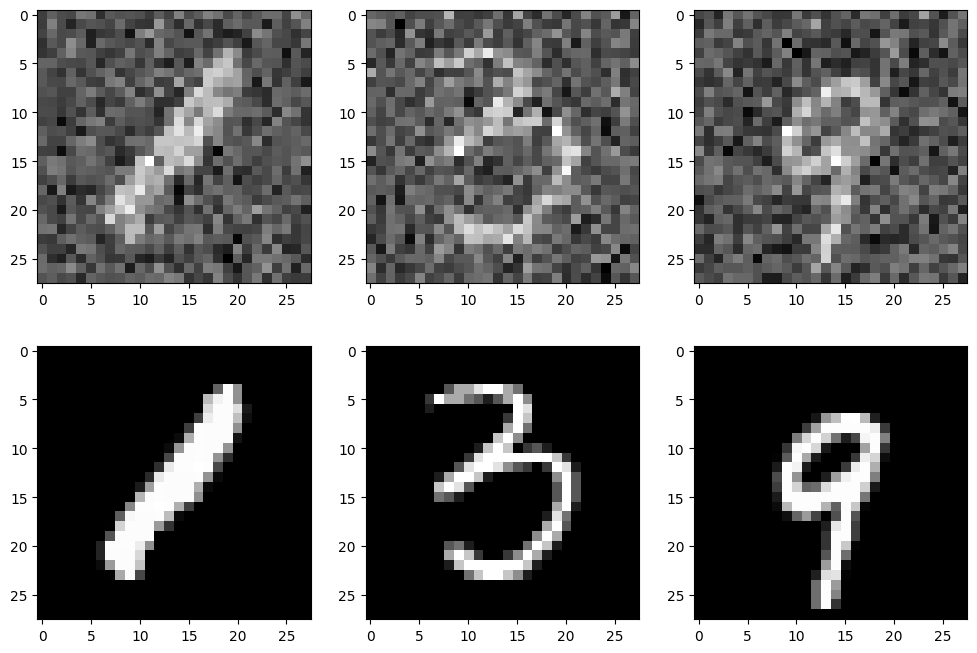

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

# Plot the first 3 training images with corresponding noisy images
_, (noisy, image) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(noisy[idx][0], cmap='gray')
  ax[1,idx].imshow(image[idx][0], cmap='gray')
fig.show()

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

### Task 2: Create and train a denoising autoencoder

Build an autoencoder neural network by filling in `__init__` and `forward`. Remember that `__init__` defines the layers or building blocks while `forward` implements the model computation that *implicitly* defines the model structure. This should be more complicated (more params, different layers, combination of CNNs/FCs) than in the instructions. Hint: You may want to create the network to have convolutional and transpose convolutional layers (see `ConvTranspose2D` function in PyTorch documentation).

We provide code for the following which you should run to validate your module.
1. Move your model to GPU so that you can train your model with GPU.
2. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
3. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class our_DAE(nn.Module): # CNN version
  def __init__(self):
    super(our_DAE, self).__init__()

    ###########################   <YOUR CODE>  ############################
    # encoder
    self.en_conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.en_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    #self.en_conv2 = nn.Conv2d(in_channels=, out_channels=, kernel_size=5)
    #self.en_fcTest = nn.Linear(784, 128)

    self.en_fc1 = nn.Linear(32*7*7, 64)
    self.en_fc2 = nn.Linear(64, 32)
    #self.en_fc3 = nn.Linear(32, 16)
    self.en_pool = nn.MaxPool2d(2,2)

    # decoder
    self.de_pool = nn.MaxPool2d(2,2)
    #self.de_fc3 = nn.Linear(16, 32)
    self.de_fc2 = nn.Linear(32, 64)
    self.de_fc1 = nn.Linear(64, 32*7*7)

    #self.de_fcTest = nn.Linear(128, 784)
    self.de_convT1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.de_convT2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.unflatten = nn.Unflatten(1, (32, 7, 7))
    #########################  <END YOUR CODE>  ############################

  def forward(self, x):
    ###########################   <YOUR CODE>  ############################
    #Testing
    #x = x.view(-1, 784)
    #x = F.relu(self.en_fcTest(x))
    #x = F.relu(self.en_fc2(x))
    #x = F.relu(self.en_fc3(x))

    #x = F.relu(self.de_fc3(x))
    #x = F.relu(self.de_fc2(x))
    #x = F.relu(self.de_fcTest(x))
    #x = x.view(-1, 1, 28, 28)
    #print(x.size())                               # 64, 1, 28, 28
    x = self.en_pool(F.relu(self.en_conv1(x)))    # 64, 16, 7, 7
    #print(x.size())
    x = self.en_pool(F.relu(self.en_conv2(x)))    # 64, 32, 2, 2
    #print(x.size())
    x = torch.flatten(x, 1)         # 64, 800
    x = F.relu(self.en_fc1(x))      # 64, 64
    x = F.relu(self.en_fc2(x))      # 64, 32
    #x = F.relu(self.en_fc3(x))      # 64, 16

    #x = F.relu(self.de_fc3(x))      # 64, 32
    x = F.relu(self.de_fc2(x))      # 64, 64
    x = F.relu(self.de_fc1(x))      # 64, 800
    x = self.unflatten(x)           # 64, 32, 5, 5
    #print(x.size())
    x = F.relu(self.de_convT1(x))     # 64, 16, 14, 14
    #print(x.size())
    x = F.sigmoid(self.de_convT2(x))     # 64, 1, 28, 28
    #print(x.size())
    return x

    #########################  <END YOUR CODE>  ############################

DAE = our_DAE().to(device)
optimizer = optim.Adam(DAE.parameters(), lr=2e-4)
loss_fn = nn.MSELoss(reduction='sum')

In [ ]:
# Training and testing code
def train(epoch, device):

  DAE.train() # we need to set the mode for our model

  for batch_idx, (noisy, images) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    noisy, images = noisy.to(device), images.to(device)
    output = DAE(noisy)
    loss = loss_fn(output, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 500 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  DAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for (noisy, images) in test_loader:
      noisy, images = noisy.to(device), images.to(device)
      output = DAE(noisy)
      test_loss += loss_fn(output, images).item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 6
for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 229.48440551757812
Epoch 1: [32000/60000] Loss: 54.495513916015625
Test result on epoch 1: Avg loss is 52.123062890625
Epoch 2: [0/60000] Loss: 53.943817138671875
Epoch 2: [32000/60000] Loss: 43.735721588134766
Test result on epoch 2: Avg loss is 36.1576078125
Epoch 3: [0/60000] Loss: 36.00007629394531
Epoch 3: [32000/60000] Loss: 30.60555648803711
Test result on epoch 3: Avg loss is 27.14430390625
Epoch 4: [0/60000] Loss: 27.195444107055664
Epoch 4: [32000/60000] Loss: 24.39775848388672
Test result on epoch 4: Avg loss is 23.103023828125
Epoch 5: [0/60000] Loss: 23.967510223388672
Epoch 5: [32000/60000] Loss: 19.63424301147461
Test result on epoch 5: Avg loss is 20.6977630859375
Epoch 6: [0/60000] Loss: 20.367206573486328
Epoch 6: [32000/60000] Loss: 19.19693374633789
Test result on epoch 6: Avg loss is 18.6020365234375


torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


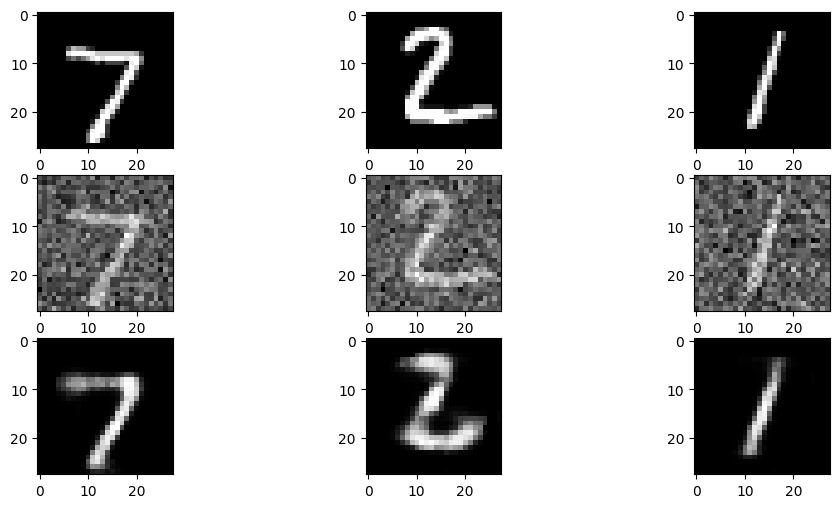

In [ ]:
# Visualization code
import matplotlib.pyplot as plt

_, (noisy, images) = next(enumerate(test_loader))
noisy, images = noisy.to(device), images.to(device)
output = DAE(noisy).cpu().detach()
noisy, images = noisy.cpu(), images.cpu()

print(images.size(), output.size())

fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(noisy[idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')

fig.show()


## Exercise 2: Build a variational autoencoder (VAE) that can generate MNIST images (60 points)

We provide boilerplate code to do the following:
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [ ]:
import torchvision
import torch

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

print(f'We are using device name "{device}"')

100%|██████████| 9912422/9912422 [00:00<00:00, 163557049.23it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 99129045.68it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54259307.99it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5870733.06it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build a VAE (variational autoencoder) given the following assumptions, which simplify the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance for each dimension independently.
3. The output distribution of the decoder $p_g(x|z)$ is an independent Bernoulli distribution for every pixel value, i.e., the output of the network is a probability value between 0 and 1 that defines the parameter of the Bernoulli distribution. (more details below)

For the reconstruction error, while we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With this assumption, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html#torch.nn.functional.binary_cross_entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels.

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with mean $\mu_j$ and variance $\sigma_j^2$, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above for the derivation and proof):

$$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2). $$


Your task here is to write a function `vae_loss` which takes as input:
1. `output` - The output of your model, i.e., the bernoulli parameter for each pixel, which is needed for the reconstruction term.
2. `mu`, `log_var` - The encoder mean and log variance which are needed for the KL term. Note it is easier to output the log of the variance, i.e., $\log(\sigma_j^2)$ instead of variance as log variance can be any real number while variance must be positive.
3. `images` - The original images needed for the reconstruction term.

and returns the  reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.

In [ ]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  # Calculate the loss

  reconstruction = F.binary_cross_entropy(output, images, reduction='sum')
  k_l = -0.5 * torch.sum(1 + log_var - (mu**2) - log_var.exp())
  return reconstruction, k_l
  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.

* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$), then generate a random vector from the Gaussian distribution with a mean of `mu` and standard deviation of `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step. Hint: First, generate a random Gaussian vector from a standard normal distribution and then shift and scale based on `mu` and `std` to create the final sample.

* Inside the `encoder` function, you should compute a `mu` and `log_var` that both have the shape of `(batch_size, latent_feature)`. One way to do this is a NN that transforms samples from the original dimension to 2x latent dimension, i.e., output a tensor of shape `(batch_size, 2*latent_feature)`.  Then, you will need to split this into two tensors of size `(batch_size, latent_feature)`. Note that both mean and the log variance can be any real number so you do not need to constrain the output in any way.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder

    # encoder
    self.en_fc1 = nn.Linear(28*28, 392)
    #self.en_fc3 = nn.Linear(512, 250)
    self.en_fc2 = nn.Linear(392, self.latent_feature*2)

    # decoder
    self.de_fc2 = nn.Linear(self.latent_feature, 392)
    #self.de_fc3 = nn.Linear(250, 512)
    self.de_fc1 = nn.Linear(392, 28*28)

    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = torch.exp(0.5 * log_var)
    return torch.randn(mu.size()) * std + mu
    #########################  <END YOUR CODE>  ############################
    return sample

  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z ~ q(z|x).
    """
    ###########################   <YOUR CODE>  ############################
    x = torch.flatten(x, 1)

    x = F.relu(self.en_fc1(x))
    #x = F.relu(self.en_fc3(x))
    x = self.en_fc2(x)

    mu, log_var = torch.chunk(x, chunks=2, dim=1)
    z = self.reparameterize(mu, log_var)

    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################

    z = F.relu(self.de_fc2(z))
    #z = F.relu(self.de_fc3(z))
    x = F.sigmoid(self.de_fc1(z))

    x = x.view(-1, 1, 28, 28)
    #########################  <END YOUR CODE>  ###########################
    return x



  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    mu, log_var, x = self.encoder(x)
    x = self.decoder(x)
    #########################  <END YOUR CODE>  ###########################


    return x, mu, log_var

In [ ]:
# Check reparameterize method by generating samples
mu_ = [-1.0, 0, 1.0]
var_ = [0.1, 0.2, 0.3]
vae = our_VAE()

torch.manual_seed(42)
for i, (m,v) in enumerate(zip(mu_, var_)):
    m_t = torch.Tensor([m])
    v_t = torch.Tensor([v])
    samples = torch.cat([vae.reparameterize(m_t, torch.log(v_t)) for _ in range(10000)])
    mean = torch.mean(samples)
    var = torch.var(samples)
    print(f'###### Test Case {i+1}: mu = {m}, var = {v} ######')
    print(f'Is mean of the samples close to the actual mean? {torch.allclose(mean, m_t, atol=1e-2)}') # True
    print(f'Is variance of the samples close to the actual variance? {torch.allclose(var, v_t, atol=1e-2)}\n') # True

###### Test Case 1: mu = -1.0, var = 0.1 ######
Is mean of the samples close to the actual mean? True
Is variance of the samples close to the actual variance? True

###### Test Case 2: mu = 0, var = 0.2 ######
Is mean of the samples close to the actual mean? True
Is variance of the samples close to the actual variance? True

###### Test Case 3: mu = 1.0, var = 0.3 ######
Is mean of the samples close to the actual mean? True
Is variance of the samples close to the actual variance? True



### Task 3: Train and validate your model
We now provide code to do the following that you must run to validate your code (you may need to increase the number of max epochs):

1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, title, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

In [ ]:
# Training code
def train(epoch, device, quiet=False):

  VAE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    output, mu, log_var = VAE(images)
    bce, kld = vae_loss(output, mu, log_var, images) # Here is a typical loss function (Mean square error)
    loss = bce + kld
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      bce_losses.append(bce/batch_size_train)
      kld_losses.append(kld/batch_size_train)
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0 and not quiet: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

# Testing code
def test(epoch, device, quiet=False):

  VAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      output, mu, log_var = VAE(images)
      bce, kld = vae_loss(output, mu, log_var, images)
      test_loss += bce+kld
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  if not quiet:
    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

# Running train and test
import torch.optim as optim

VAE = our_VAE()
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)

train_losses = []
train_counter = []
bce_losses = []
kld_losses = []
test_losses = []
test_counter = []
max_epoch = 5

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 551.2813720703125
Epoch 1: [6400/60000] Loss: 276.3609924316406
Epoch 1: [12800/60000] Loss: 230.48971557617188
Epoch 1: [19200/60000] Loss: 224.34620666503906
Epoch 1: [25600/60000] Loss: 209.63502502441406
Epoch 1: [32000/60000] Loss: 197.80941772460938
Epoch 1: [38400/60000] Loss: 188.17684936523438
Epoch 1: [44800/60000] Loss: 186.74754333496094
Epoch 1: [51200/60000] Loss: 172.02484130859375
Epoch 1: [57600/60000] Loss: 168.62742614746094
Test result on epoch 1: Avg loss is 169.27137756347656
Epoch 2: [0/60000] Loss: 174.66683959960938
Epoch 2: [6400/60000] Loss: 165.47120666503906
Epoch 2: [12800/60000] Loss: 162.188232421875
Epoch 2: [19200/60000] Loss: 152.96336364746094
Epoch 2: [25600/60000] Loss: 156.949462890625
Epoch 2: [32000/60000] Loss: 152.3607177734375
Epoch 2: [38400/60000] Loss: 160.25221252441406
Epoch 2: [44800/60000] Loss: 148.7212371826172
Epoch 2: [51200/60000] Loss: 152.01368713378906
Epoch 2: [57600/60000] Loss: 142.00961303710938
Tes

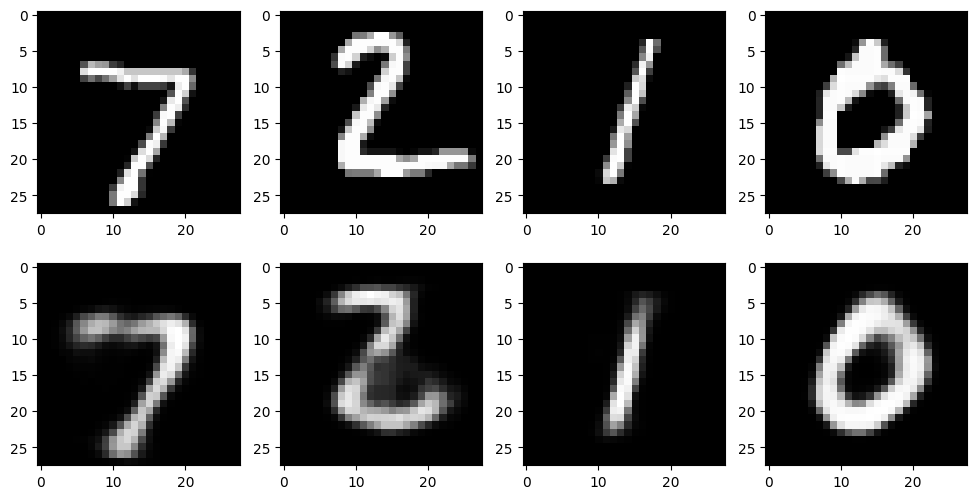

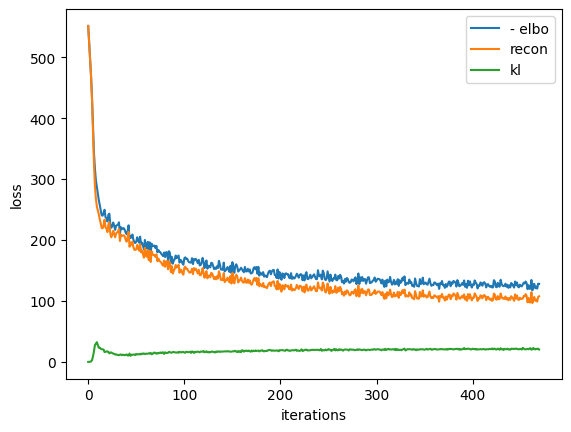

In [ ]:
# Visualization code
import matplotlib.pyplot as plt

batch_idx, (images, _) = next(enumerate(test_loader))
output = VAE(images)[0].detach()
images = images.cpu()


fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)

for idx in range(4):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()

plt.figure()
plt.plot(train_losses,label = '- elbo')
plt.plot([i.item() for i in bce_losses],label = 'recon')
plt.plot([i.item() for i in kld_losses],label = 'kl')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

# Exercise 3: Exploring the latent space of VAE (20 points)

### Task 1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training. We provide the function ``plot_latent`` to simplify your exploration.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for 10 epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization **before training** (so you can see what the latent space looks like at initialization) AND after the 5th and 10th epoch. You should use the **test** data for plotting this visualization task. With the correct training you will see some clusters in the latent space after some epochs.


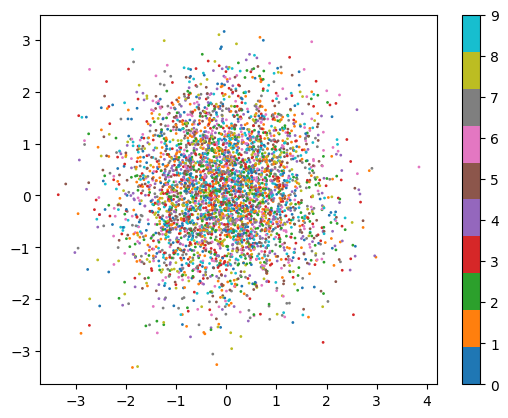

Epoch 1: [0/60000] Loss: 552.6396484375
Epoch 1: [6400/60000] Loss: 264.40130615234375
Epoch 1: [12800/60000] Loss: 230.39022827148438
Epoch 1: [19200/60000] Loss: 227.4661102294922
Epoch 1: [25600/60000] Loss: 202.61968994140625
Epoch 1: [32000/60000] Loss: 210.35781860351562
Epoch 1: [38400/60000] Loss: 202.7891387939453
Epoch 1: [44800/60000] Loss: 204.4199981689453
Epoch 1: [51200/60000] Loss: 190.66090393066406
Epoch 1: [57600/60000] Loss: 192.6673126220703
Test result on epoch 1: Avg loss is 190.75204467773438
Epoch 2: [0/60000] Loss: 199.92160034179688
Epoch 2: [6400/60000] Loss: 185.14109802246094
Epoch 2: [12800/60000] Loss: 191.70623779296875
Epoch 2: [19200/60000] Loss: 184.7427520751953
Epoch 2: [25600/60000] Loss: 184.20144653320312
Epoch 2: [32000/60000] Loss: 183.38894653320312
Epoch 2: [38400/60000] Loss: 183.17459106445312
Epoch 2: [44800/60000] Loss: 178.68821716308594
Epoch 2: [51200/60000] Loss: 184.82144165039062
Epoch 2: [57600/60000] Loss: 177.76019287109375
Test

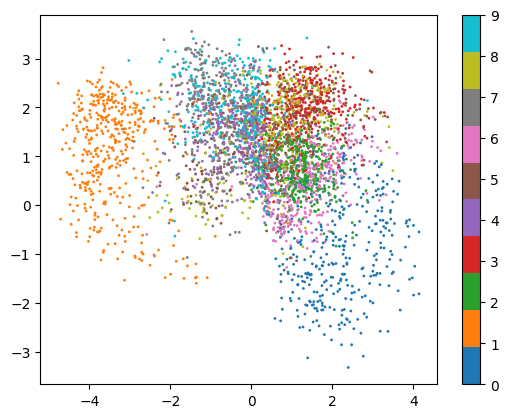

Test result on epoch 5: Avg loss is 168.3423614501953
Epoch 6: [0/60000] Loss: 174.26382446289062
Epoch 6: [6400/60000] Loss: 161.9981689453125
Epoch 6: [12800/60000] Loss: 172.3119659423828
Epoch 6: [19200/60000] Loss: 173.6334686279297
Epoch 6: [25600/60000] Loss: 171.36314392089844
Epoch 6: [32000/60000] Loss: 172.2443389892578
Epoch 6: [38400/60000] Loss: 166.41502380371094
Epoch 6: [44800/60000] Loss: 170.93112182617188
Epoch 6: [51200/60000] Loss: 164.06236267089844
Epoch 6: [57600/60000] Loss: 172.6756134033203
Test result on epoch 6: Avg loss is 166.2501678466797
Epoch 7: [0/60000] Loss: 171.97506713867188
Epoch 7: [6400/60000] Loss: 169.60665893554688
Epoch 7: [12800/60000] Loss: 159.8879852294922
Epoch 7: [19200/60000] Loss: 177.37376403808594
Epoch 7: [25600/60000] Loss: 167.43850708007812
Epoch 7: [32000/60000] Loss: 152.18370056152344
Epoch 7: [38400/60000] Loss: 162.7584228515625
Epoch 7: [44800/60000] Loss: 163.0531005859375
Epoch 7: [51200/60000] Loss: 165.5686798095703

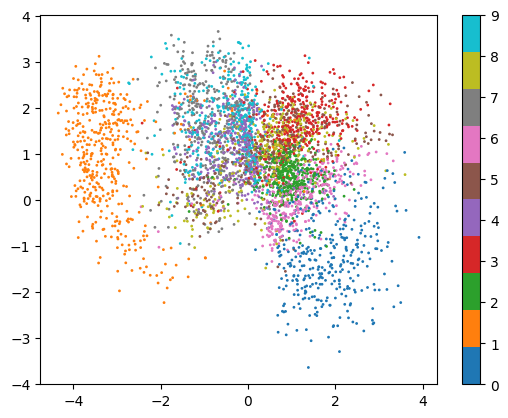

Test result on epoch 10: Avg loss is 162.61294555664062


In [ ]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

import torch.optim as optim

VAE = our_VAE(latent_feature=2)
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)

train_losses = []
train_counter = []
bce_losses = []
kld_losses = []
test_losses = []
test_counter = []
max_epoch = 10
###########################   <YOUR CODE>  ############################
# plot the latent space before training using 'plot_latent' method
# plot the latent space after training 5 epochs and 10 epochs
plot_latent(VAE, test_loader)
for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  if epoch == 5 or epoch == 10:
    plot_latent(VAE, test_loader)
  test(epoch, device=device)


#########################  <END YOUR CODE>  ###########################

### Task 2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space.
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels). We have already selected two latent images from the test set `z0` and `z1` and their corresponding reconstructions `x0` and `x1` that correspond to a 1 and an 8 digit respectively.
Given this setup, your task is to do the following:

1. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$, i.e., 11 points between 0 and 1. It is recommended to use broadcasting (possibly with reshaping) to create these without a loop.

2. Compute the **latent** linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the VAE decoder.

We provide code to select initial examples and plot the visualization of the interpolations.

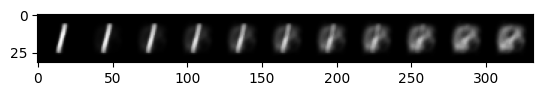

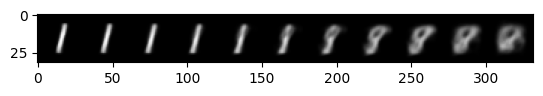

In [ ]:
def linear_interpolation(x0, x1):
  ###########################   <YOUR CODE>  ############################
  # The output x_interp should be a tensor that has shape (11, 1, 28, 28)
  #print(x0.size())
  #print(x1.size())
  a = torch.tensor([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
  a = a.view(-1, 1, 1, 1)
  x_interp = a*x1 + (1-a) * x0
  #########################  <END YOUR CODE>  ###########################
  return x_interp

def latent_linear_interpolation(z0, z1, VAE):
  ###########################   <YOUR CODE>  ############################
  # The output x_interp_latent should be a tensor that has shape (11, 1, 28, 28)
  # Note that first you will need to interpolate between z0 and z1
  #  then you will need to decode these z's via the VAE decoder to get
  #  reconstructed images in the image space.
  #print(z0.size())
  #print(z1.size())
  a = torch.tensor([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
  a = a.view(-1, 1)
  x_interp_latent = a*z1 + (1-a) * z0
  x_interp_latent = VAE.decoder(x_interp_latent)
  #########################  <END YOUR CODE>  ###########################
  return x_interp_latent

import numpy as np
with torch.no_grad():
  images,label = next(enumerate(test_loader))[1]
  #print(images.shape)
  _,_,z = VAE.encoder(images)
  z = z.to('cpu').detach().numpy()
  z0 = z[label==1][0]
  z1 = z[label==8][0]
  x0 = VAE.decoder(torch.Tensor(z0))
  x1 = VAE.decoder(torch.Tensor(z1))

  # Visualize linear interpolation in x space
  xp = linear_interpolation(x0, x1)
  grid_img = torchvision.utils.make_grid(xp, nrow=11)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()

  # Visualize latent linear interpolation in z space that has been reconstructed in x space
  xzp = latent_linear_interpolation(z0, z1, VAE)
  grid_img = torchvision.utils.make_grid(xzp, nrow=11)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.show()